# Прогнозирование обводнённости скважин с помощью методов машинного обучения

Version 2.3

Вопрос предсказания добычи скважинами нефти и газа является одним из самых важных в нефтяной и газовой промышленности. Без обоснованного прогноза добычи невозможно принимать решения о рентабельности проектов, капитальных вложениях, бурении новых и операционном планировании эксплуатации существующих скважин.

В данной статье изложена попытка создать модель машинного обучения по предсказанию одного из параметров работы скважин и проверить способность модели предсказать обводнённость существующих скважин и скважин, которые планируется пробурить (кандидаты на бурение).

Поэтому идея попробовать использовать такие ьолее "простые" методы, как машинное обучение, прямо скажем, витает в воздухе.

План построения модели был следующий:

- Создать **MVP** (minimal viable product - минимально работающий продукт)
- Проверить, что модель имеет предсказательную силу.
- Масштабировать модель на большее количество скважин в случае положительного результата


**Спойлер: как прогнозируют добычу нефти и газа: обзор для не специалистов**

В настоящий момент кроме классического аналитического способа оценки  (эксель + метод матбаланса, на котором мы не будем останавливаться) общепринятым является построение геологической (статической) и гидродинамической (динамической) моделей, на основе которой принимаются решения.

Геологическая модель строится на основе скважинных данных (часто с использованием сейсмики). В начале строится трехмерная сетка (каркас) продуктивных пластов. Далее каждой ячееке сетки присваивают такие свойства породы как пористость, проницаемость, водо- нефте- газонасыщенности, давление и прочие.

После этого на основе статической модели рассчитывается динамическая модель, которая отличается от геологической тем, что она расчитывает как вышеукзанные параметры ячеек меняются во времени в зависмости от того сколько добывают скважины и наоборот. Динамическая модель помогает ответить на вопрос где бурить новые скважины и сколько возможно добыть нефти.

Гидродинамическая модель в 3D выглядит вот так:

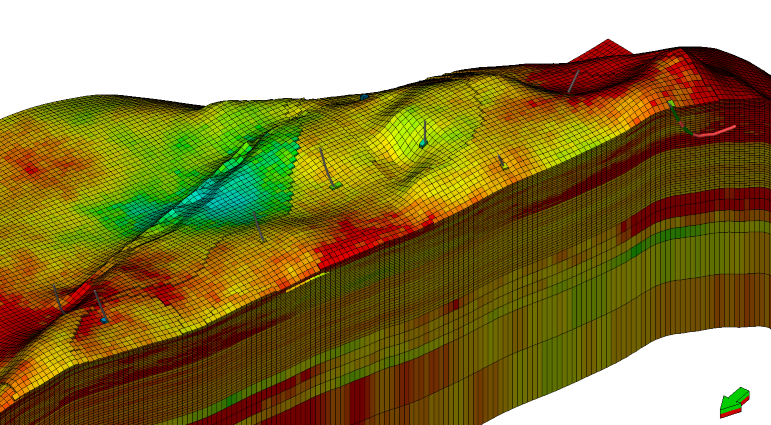

Недостаток подхода с построением полноценной гидродинамической модели в том, что на постройку модели нужно очень много времени (от нескольких месяцев до года и даже больше). Это зависит от количества скважин и имеющихся данных по месторождению. Более того, построенная гидродинамическая модель является сложной системой с высокой чувствительностью к входным данным. Поэтому любая некорректность в данных может привести к неверным результатам. Это не удивительно. Протяжённость месторождений достигать десятков километров. А типичный диаметр скважин находиться в пределах 10 - 15 см. Скважины в свою очередь, пробурены на глубины порядка 3-х километров и на расстояниях 250 - 1000 метров друг от друга. Таким образом, модель строится по крайне ограниченном данным, которые можно охарактеризовать как "точечные уколы".

**Что такое скважина и скважинные данные**

Обычно скважину представляют себе как дырку в земле. Это не совсем так. Классическое определение скважины звучит так. **Скважина - это цилиндрическая горная выработка, длинной многократно превышающей её диаметр**.  Типично - это 3-х километровое (бывает конечно и больше, бывает и меньше) отверстие в которую спущены несколько вложенных друг в друга колонн обсадных труб (для предотвращения обвалов). Пространство между колоннами обсадных труб и горной породой для герметичности цементируется. На поверхности устанавливается фонтанная арматура, которая герметизирует скважину от окружающей среды.

**pic** - _картинка скважины в разрезе. нарисовать?_

Скважины бурят не только для добычи нефти и газа. Через скважины получают подавляющее большинство данных о недрах. Скважинные данные включают в себя:

* данные полученные при спуске приборов в скважину (например давление, температура, глубина нефте/газо-насыщенного пласта, кажущееся сопротивление породы, радиоактивность и прочие..),

* замеряемые на поверхности - количество добываемых нефти, газа и попутной воды, их состав.

По типу основного добываемого флюида скважины можно разделить на нефтяные и газовые. В данной статье рассматриваются нефтяные скважины. Это значит, что на поверхности мы получаем нефть с растворённым в ней газом и попутную воду. Как правило в начале эксплуатации скважин добывается чистая нефть, но позже скважина обводняется и доля воды увеличивается. Когда доля воды увеличивается, а доля нефти уменьшаетя до определённого предела - скважина не перестаёт быть рентабельной и её останавливают. Обводнённость чаще выражают в процентах и рассчитывают как отношение количества добытой воды к добытой жидкости т.е. Qнефти/(Qнефи + Qводы)*100%

Типичный профиль добычи нефти выглядит вот так:

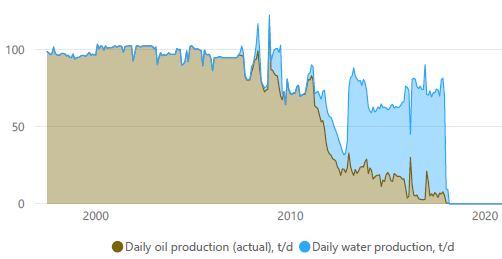

**Конец спойлера**

Входными данными для обучению модели были выбраны следующие параметры скважин:

- ST: 0 - основной ствол скважины, 1 - боковой ствол
- Cum oil: накопленная добыча нефти
- Days: количество дней работы скважины (до момента обводнения (и её остановки по нерентабельности) или до текущего момента в случае если скважина в работе).
- In prod: скважина в работе/остановлена по обводнению
- Q oil: текущий дебит нефти
- wct: текущая обводнённость
- Top perf: глубина верха интервала перфорации - глубина верха и низа. (Интервал обсадной колонны перфорируют, чтобы в скважину поступала нефть, а не подошвенные воды, например)
- Bottom perf: глубина низа интервала перфорации
- x, y: координаты скважины

**Замечания**
1. Скважинные данные являются собственностью компаниий, владеющей лицензией для разработки месторождения. Поэтому для иллюстрации выполенной работы были сгенерированы **_искусственные скважинные данные_**, которые доступны для данной работы.
2. Данные по добыче фактически являются временными рядами, что предполагает построение более сложной модели. С целью упрощения и ускорения построения MVP было принято решение построить модель на конкретно выбранную дату.

Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import pylab
from pylab import rcParams
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.metrics.pairwise import euclidean_distances

Загружаем исходные данные на определённую дату из экселя и визуализируем датафрейм.

In [3]:
data_path = 'art_df.xlsx'
df = pd.read_excel(data_path, sheet_name='artificial')

In [4]:
df

Well  ST  Cum prod  Days  In prod       Q oil    wct  Top perf  \
0    Well-1   0  238664.8  1619        1  489.402060   15.3  -2527.00   
1    Well-2   0  277066.4  1808        1  138.328155    8.2  -2532.30   
2    Well-3   0   59582.4   566        0    0.000000  100.0  -2671.29   
3    Well-4   0  167831.2  1540        0    0.000000  100.0  -2557.90   
4    Well-5   1    9214.8   189        1  362.064735   43.9  -2535.00   
5    Well-6   0  182646.4  1473        0    0.000000  100.0  -2567.50   
6    Well-7   0  262283.6  1613        1  338.000000   81.5  -2516.00   
7    Well-8   0   81975.2  1461        0    0.000000  100.0  -2517.70   
8    Well-9   0   73682.6  1784        1  129.862549   88.2  -2532.13   
9   Well-10   0   12882.2   438        0    0.000000  100.0  -2701.81   
10  Well-11   0   31826.8   779        0    0.000000  100.0  -2719.79   
11  Well-12   0   99653.2  1376        0    0.000000  100.0  -2550.20   
12  Well-13   0  189488.2  1522        0    0.000000  100.0  -2515.05   
13  Well-14   0  134580.8  1516        1  373.000000   80.8  -2521.98   
14  Well-15   1       0.0     0        1    0.000000    NaN   2519.00   
15  Well-16   1       0.0     0        0    0.000000    NaN  -2514.00   

    Bottom perf             x             y  
0      -2564.00  524145.02600  5.641074e+06  
1      -2558.30  524081.14400  5.641253e+06  
2      -2684.25  524131.34300  5.640786e+06  
3      -2626.90  524280.75000  5.641674e+06  
4      -2559.00  524338.87300  5.641487e+06  
5      -2573.50  524508.49100  5.641896e+06  
6      -2533.50  524637.84900  5.642186e+06  
7      -2541.10  524689.00200  5.642786e+06  
8      -2541.12  524973.41800  5.643400e+06  
9      -2742.18  525143.07400  5.643242e+06  
10     -2741.34  524905.59000  5.643592e+06  
11     -2574.20  525094.35200  5.643607e+06  
12     -2528.05  524697.49700  5.642445e+06  
13     -2588.96  524728.26500  5.643048e+06  
14     -2552.00  524684.76734  5.642886e+06  
15     -2786.00  524589.70000  5.642625e+06

Проверяем местоположение скважин - строим карту местоположений скважин. В данном случае это карта забоев.

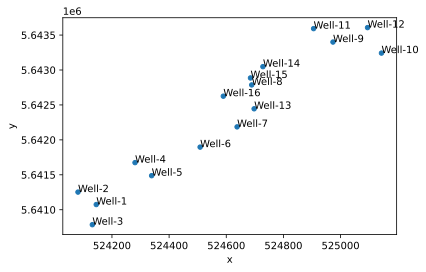

In [5]:
ax = df.plot(kind='scatter', x='x', y='y')
df[['x','y','Well']].apply(lambda row: ax.text(*row),axis=1);
rcParams['figure.figsize'] = [11, 8]

В процессепостроения модели было выявлено, что загрузка координат скважинв модель "как есть" работает неплохо. Но значительное улучшение скора происходит если трансформировать координаты в матрицу расстояний между скважинами. Таким образом мы даём возможность алгоритму сразу распознать, что ближайшие скважины имеют больший вес, чем удалённые.

# Конструирование признаков (feature engineering)

Рассчитываем матрицу евклидовых расстояний между скважинами из их координат.

In [6]:
distance = pd.DataFrame(euclidean_distances(df[['x', 'y']]))
distance

0            1            2            3            4  \
0      0.000000   189.421106   288.716421   615.262717   456.372864   
1    189.421106     0.000000   469.407884   466.628981   348.670679   
2    288.716421   469.407884     0.000000   900.972335   731.601740   
3    615.262717   466.628981   900.972335     0.000000   195.774972   
4    456.372864   348.670679   731.601740   195.774972     0.000000   
5    898.857800   772.699987  1172.782918   318.032440   442.717650   
6   1215.932267  1086.688925  1488.784179   623.801585   759.726354   
7   1796.219742  1649.621659  2076.542229  1184.350737  1345.080138   
8   2468.770961  2325.320321  2746.315419  1859.369003  2015.001471   
9   2386.388418  2255.028391  2656.273901  1789.085861  1930.030184   
10  2630.198784  2480.527815  2911.075881  2016.954562  2179.639701   
11  2704.505620  2562.877209  2980.661690  2096.609203  2249.889550   
12  1477.629961  1342.044720  1752.805451   875.857537  1022.273019   
13  2058.102461  1908.469405  2339.555698  1444.686145  1608.420761   
14  1890.507206  1741.457691  2171.905805  1277.295668  1440.799154   
15  1613.473161  1463.841835  1895.628194   999.812373  1165.147639   

              5            6            7            8            9  \
0    898.857800  1215.932267  1796.219742  2468.770961  2386.388418   
1    772.699987  1086.688925  1649.621659  2325.320321  2255.028391   
2   1172.782918  1488.784179  2076.542229  2746.315419  2656.273901   
3    318.032440   623.801585  1184.350737  1859.369003  1789.085861   
4    442.717650   759.726354  1345.080138  2015.001471  1930.030184   
5      0.000000   317.076286   907.900749  1573.786734  1487.697361   
6    317.076286     0.000000   602.461546  1259.578709  1170.705311   
7    907.900749   602.461546     0.000000   676.465868   643.371445   
8   1573.786734  1259.578709   676.465868     0.000000   231.820015   
9   1487.697361  1170.705311   643.371445   231.820015     0.000000   
10  1741.614700  1431.512178   834.559731   203.812548   423.108119   
11  1807.881205  1492.367717   915.208175   239.544905   367.995616   
12   580.026491   265.661865   341.512674   994.231110   913.270777   
13  1172.420868   866.877127   264.790129   428.880556   457.902363   
14  1005.302778   701.808484   100.042061   589.345168   580.229349   
15   733.402963   442.034170   189.060599   864.479741   828.558009   

             10           11           12           13           14  \
0   2630.198784  2704.505620  1477.629961  2058.102461  1890.507206   
1   2480.527815  2562.877209  1342.044720  1908.469405  1741.457691   
2   2911.075881  2980.661690  1752.805451  2339.555698  2171.905805   
3   2016.954562  2096.609203   875.857537  1444.686145  1277.295668   
4   2179.639701  2249.889550  1022.273019  1608.420761  1440.799154   
5   1741.614700  1807.881205   580.026491  1172.420868  1005.302778   
6   1431.512178  1492.367717   265.661865   866.877127   701.808484   
7    834.559731   915.208175   341.512674   264.790129   100.042061   
8    203.812548   239.544905   994.231110   428.880556   589.345168   
9    423.108119   367.995616   913.270777   457.902363   580.229349   
10     0.000000   189.324405  1166.089706   572.268417   739.740791   
11   189.324405     0.000000  1227.856257   667.942740   828.864385   
12  1166.089706  1227.856257     0.000000   604.054103   441.542936   
13   572.268417   667.942740   604.054103     0.000000   167.651680   
14   739.740791   828.864385   441.542936   167.651680     0.000000   
15  1017.142868  1103.574430   210.260488   444.874811   277.619140   

             15  
0   1613.473161  
1   1463.841835  
2   1895.628194  
3    999.812373  
4   1165.147639  
5    733.402963  
6    442.034170  
7    189.060599  
8    864.479741  
9    828.558009  
10  1017.142868  
11  1103.574430  
12   210.260488  
13   444.874811  
14   277.619140  
15     0.000000

Извлекаем список имён скважин. Присваеваем имена скважин колонкам матрицы расстояний. Таким образом именуем столбцы с расстояними именами скважин, расстояния до которых вычислены.

In [7]:
well_names = df['Well']
distance.columns = well_names
distance

Well       Well-1       Well-2       Well-3       Well-4       Well-5  \
0        0.000000   189.421106   288.716421   615.262717   456.372864   
1      189.421106     0.000000   469.407884   466.628981   348.670679   
2      288.716421   469.407884     0.000000   900.972335   731.601740   
3      615.262717   466.628981   900.972335     0.000000   195.774972   
4      456.372864   348.670679   731.601740   195.774972     0.000000   
5      898.857800   772.699987  1172.782918   318.032440   442.717650   
6     1215.932267  1086.688925  1488.784179   623.801585   759.726354   
7     1796.219742  1649.621659  2076.542229  1184.350737  1345.080138   
8     2468.770961  2325.320321  2746.315419  1859.369003  2015.001471   
9     2386.388418  2255.028391  2656.273901  1789.085861  1930.030184   
10    2630.198784  2480.527815  2911.075881  2016.954562  2179.639701   
11    2704.505620  2562.877209  2980.661690  2096.609203  2249.889550   
12    1477.629961  1342.044720  1752.805451   875.857537  1022.273019   
13    2058.102461  1908.469405  2339.555698  1444.686145  1608.420761   
14    1890.507206  1741.457691  2171.905805  1277.295668  1440.799154   
15    1613.473161  1463.841835  1895.628194   999.812373  1165.147639   

Well       Well-6       Well-7       Well-8       Well-9      Well-10  \
0      898.857800  1215.932267  1796.219742  2468.770961  2386.388418   
1      772.699987  1086.688925  1649.621659  2325.320321  2255.028391   
2     1172.782918  1488.784179  2076.542229  2746.315419  2656.273901   
3      318.032440   623.801585  1184.350737  1859.369003  1789.085861   
4      442.717650   759.726354  1345.080138  2015.001471  1930.030184   
5        0.000000   317.076286   907.900749  1573.786734  1487.697361   
6      317.076286     0.000000   602.461546  1259.578709  1170.705311   
7      907.900749   602.461546     0.000000   676.465868   643.371445   
8     1573.786734  1259.578709   676.465868     0.000000   231.820015   
9     1487.697361  1170.705311   643.371445   231.820015     0.000000   
10    1741.614700  1431.512178   834.559731   203.812548   423.108119   
11    1807.881205  1492.367717   915.208175   239.544905   367.995616   
12     580.026491   265.661865   341.512674   994.231110   913.270777   
13    1172.420868   866.877127   264.790129   428.880556   457.902363   
14    1005.302778   701.808484   100.042061   589.345168   580.229349   
15     733.402963   442.034170   189.060599   864.479741   828.558009   

Well      Well-11      Well-12      Well-13      Well-14      Well-15  \
0     2630.198784  2704.505620  1477.629961  2058.102461  1890.507206   
1     2480.527815  2562.877209  1342.044720  1908.469405  1741.457691   
2     2911.075881  2980.661690  1752.805451  2339.555698  2171.905805   
3     2016.954562  2096.609203   875.857537  1444.686145  1277.295668   
4     2179.639701  2249.889550  1022.273019  1608.420761  1440.799154   
5     1741.614700  1807.881205   580.026491  1172.420868  1005.302778   
6     1431.512178  1492.367717   265.661865   866.877127   701.808484   
7      834.559731   915.208175   341.512674   264.790129   100.042061   
8      203.812548   239.544905   994.231110   428.880556   589.345168   
9      423.108119   367.995616   913.270777   457.902363   580.229349   
10       0.000000   189.324405  1166.089706   572.268417   739.740791   
11     189.324405     0.000000  1227.856257   667.942740   828.864385   
12    1166.089706  1227.856257     0.000000   604.054103   441.542936   
13     572.268417   667.942740   604.054103     0.000000   167.651680   
14     739.740791   828.864385   441.542936   167.651680     0.000000   
15    1017.142868  1103.574430   210.260488   444.874811   277.619140   

Well      Well-16  
0     1613.473161  
1     1463.841835  
2     1895.628194  
3      999.812373  
4     1165.147639  
5      733.402963  
6      442.034170  
7      189.060599  
8      864.479741  
9      828.558009  
10    1017.142868  
11    1103.574430  
12     210.260

Объединяем датасет парметров работы скважин с матрицей расстояний между скважинами. Таким образом в датасет добавляем N-столбцов, где N - количество скважин в датасете. Т.е. конструируем N новых признаков (feature engineering) где параметр удалённости является весом (вкладом/влиянием) скважин друг на друга.

In [8]:
df_distance = pd.concat([df.drop(['x', 'y'], axis=1), distance], axis=1)
df_distance

Well  ST  Cum prod  Days  In prod       Q oil    wct  Top perf  \
0    Well-1   0  238664.8  1619        1  489.402060   15.3  -2527.00   
1    Well-2   0  277066.4  1808        1  138.328155    8.2  -2532.30   
2    Well-3   0   59582.4   566        0    0.000000  100.0  -2671.29   
3    Well-4   0  167831.2  1540        0    0.000000  100.0  -2557.90   
4    Well-5   1    9214.8   189        1  362.064735   43.9  -2535.00   
5    Well-6   0  182646.4  1473        0    0.000000  100.0  -2567.50   
6    Well-7   0  262283.6  1613        1  338.000000   81.5  -2516.00   
7    Well-8   0   81975.2  1461        0    0.000000  100.0  -2517.70   
8    Well-9   0   73682.6  1784        1  129.862549   88.2  -2532.13   
9   Well-10   0   12882.2   438        0    0.000000  100.0  -2701.81   
10  Well-11   0   31826.8   779        0    0.000000  100.0  -2719.79   
11  Well-12   0   99653.2  1376        0    0.000000  100.0  -2550.20   
12  Well-13   0  189488.2  1522        0    0.000000  100.0  -2515.05   
13  Well-14   0  134580.8  1516        1  373.000000   80.8  -2521.98   
14  Well-15   1       0.0     0        1    0.000000    NaN   2519.00   
15  Well-16   1       0.0     0        0    0.000000    NaN  -2514.00   

    Bottom perf       Well-1  ...       Well-7       Well-8       Well-9  \
0      -2564.00     0.000000  ...  1215.932267  1796.219742  2468.770961   
1      -2558.30   189.421106  ...  1086.688925  1649.621659  2325.320321   
2      -2684.25   288.716421  ...  1488.784179  2076.542229  2746.315419   
3      -2626.90   615.262717  ...   623.801585  1184.350737  1859.369003   
4      -2559.00   456.372864  ...   759.726354  1345.080138  2015.001471   
5      -2573.50   898.857800  ...   317.076286   907.900749  1573.786734   
6      -2533.50  1215.932267  ...     0.000000   602.461546  1259.578709   
7      -2541.10  1796.219742  ...   602.461546     0.000000   676.465868   
8      -2541.12  2468.770961  ...  1259.578709   676.465868     0.000000   
9      -2742.18  2386.388418  ...  1170.705311   643.371445   231.820015   
10     -2741.34  2630.198784  ...  1431.512178   834.559731   203.812548   
11     -2574.20  2704.505620  ...  1492.367717   915.208175   239.544905   
12     -2528.05  1477.629961  ...   265.661865   341.512674   994.231110   
13     -2588.96  2058.102461  ...   866.877127   264.790129   428.880556   
14     -2552.00  1890.507206  ...   701.808484   100.042061   589.345168   
15     -2786.00  1613.473161  ...   442.034170   189.060599   864.479741   

        Well-10      Well-11      Well-12      Well-13      Well-14  \
0   2386.388418  2630.198784  2704.505620  1477.629961  2058.102461   
1   2255.028391  2480.527815  2562.877209  1342.044720  1908.469405   
2   2656.273901  2911.075881  2980.661690  1752.805451  2339.555698   
3   1789.085861  2016.954562  2096.609203   875.857537  1444.686145   
4   1930.030184  2179.639701  2249.889550  1022.273019  1608.420761   
5   1487.697361  1741.614700  1807.881205   580.026491  1172.420868   
6   1170.705311  1431.512178  1492.367717   265.661865   866.877127   
7    643.371445   834.559731   915.208175   341.512674   264.790129   
8    231.820015   203.812548   239.544905   994.231110   428.880556   
9      0.000000   423.108119   367.995616   913.270777   457.902363   
10   423.108119     0.000000   189.324405  1166.089706   572.268417   
11   367.995616   189.324405     0.000000  1227.856257   667.942740   
12   913.270777  1166.089706  1227.856257     0.000000   604.054103   
13   457.902363   572.268417   667.942740   604.054103     0.000000   
14   580.229349   739.740791   828.864385   441.542936   167.651680   
15   828.558009  1017.142868  1103.574430   210.260488   444.874811   

        Well-15      Well-16  
0   1890.507206  1613.473161  
1   1741.457691  1463.841835  
2   2171.905805  1895.628194  
3   1277.295668   999.812373  
4   1440.799154  1165.147639  
5   1005.302778   733.402963  
6    701.808484   442.034170  
7    100.042061 

# Проверка гипотезы

Создаём тренировочный дата сет, удаляя из него скважины, выбранные для теста и прогноза

In [9]:
df_train_1 = df_distance.drop([12, 13, 14, 15], axis=0)
df_train_1

Well  ST  Cum prod  Days  In prod       Q oil    wct  Top perf  \
0    Well-1   0  238664.8  1619        1  489.402060   15.3  -2527.00   
1    Well-2   0  277066.4  1808        1  138.328155    8.2  -2532.30   
2    Well-3   0   59582.4   566        0    0.000000  100.0  -2671.29   
3    Well-4   0  167831.2  1540        0    0.000000  100.0  -2557.90   
4    Well-5   1    9214.8   189        1  362.064735   43.9  -2535.00   
5    Well-6   0  182646.4  1473        0    0.000000  100.0  -2567.50   
6    Well-7   0  262283.6  1613        1  338.000000   81.5  -2516.00   
7    Well-8   0   81975.2  1461        0    0.000000  100.0  -2517.70   
8    Well-9   0   73682.6  1784        1  129.862549   88.2  -2532.13   
9   Well-10   0   12882.2   438        0    0.000000  100.0  -2701.81   
10  Well-11   0   31826.8   779        0    0.000000  100.0  -2719.79   
11  Well-12   0   99653.2  1376        0    0.000000  100.0  -2550.20   

    Bottom perf       Well-1  ...       Well-7       Well-8       Well-9  \
0      -2564.00     0.000000  ...  1215.932267  1796.219742  2468.770961   
1      -2558.30   189.421106  ...  1086.688925  1649.621659  2325.320321   
2      -2684.25   288.716421  ...  1488.784179  2076.542229  2746.315419   
3      -2626.90   615.262717  ...   623.801585  1184.350737  1859.369003   
4      -2559.00   456.372864  ...   759.726354  1345.080138  2015.001471   
5      -2573.50   898.857800  ...   317.076286   907.900749  1573.786734   
6      -2533.50  1215.932267  ...     0.000000   602.461546  1259.578709   
7      -2541.10  1796.219742  ...   602.461546     0.000000   676.465868   
8      -2541.12  2468.770961  ...  1259.578709   676.465868     0.000000   
9      -2742.18  2386.388418  ...  1170.705311   643.371445   231.820015   
10     -2741.34  2630.198784  ...  1431.512178   834.559731   203.812548   
11     -2574.20  2704.505620  ...  1492.367717   915.208175   239.544905   

        Well-10      Well-11      Well-12      Well-13      Well-14  \
0   2386.388418  2630.198784  2704.505620  1477.629961  2058.102461   
1   2255.028391  2480.527815  2562.877209  1342.044720  1908.469405   
2   2656.273901  2911.075881  2980.661690  1752.805451  2339.555698   
3   1789.085861  2016.954562  2096.609203   875.857537  1444.686145   
4   1930.030184  2179.639701  2249.889550  1022.273019  1608.420761   
5   1487.697361  1741.614700  1807.881205   580.026491  1172.420868   
6   1170.705311  1431.512178  1492.367717   265.661865   866.877127   
7    643.371445   834.559731   915.208175   341.512674   264.790129   
8    231.820015   203.812548   239.544905   994.231110   428.880556   
9      0.000000   423.108119   367.995616   913.270777   457.902363   
10   423.108119     0.000000   189.324405  1166.089706   572.268417   
11   367.995616   189.324405     0.000000  1227.856257   667.942740   

        Well-15      Well-16  
0   1890.507206  1613.473161  
1   1741.457691  1463.841835  
2   2171.905805  1895.628194  
3   1277.295668   999.812373  
4   1440.799154  1165.147639  
5   1005.302778   733.402963  
6    701.808484   442.034170  
7    100.042061   189.060599  
8    589.345168   864.479741  
9    580.229349   828.558009  
10   739.740791  1017.142868  
11   828.864385  1103.574430  

[12 rows x 25 columns]

Создаём тестовый датасет

In [10]:
df_test_1 = df_distance.loc[[12, 13]]
df_test_1

Well  ST  Cum prod  Days  In prod  Q oil    wct  Top perf  Bottom perf  \
12  Well-13   0  189488.2  1522        0    0.0  100.0  -2515.05     -2528.05   
13  Well-14   0  134580.8  1516        1  373.0   80.8  -2521.98     -2588.96   

         Well-1  ...      Well-7      Well-8      Well-9     Well-10  \
12  1477.629961  ...  265.661865  341.512674  994.231110  913.270777   
13  2058.102461  ...  866.877127  264.790129  428.880556  457.902363   

        Well-11      Well-12     Well-13     Well-14     Well-15     Well-16  
12  1166.089706  1227.856257    0.000000  604.054103  441.542936  210.260488  
13   572.268417   667.942740  604.054103    0.000000  167.651680  444.874811  

[2 rows x 25 columns]

Создаём тренировочный DataFrame признаков X_1. Удаляем категорийный признак (имя скважины) и предсказываемое значение wct.

In [11]:
x_1 = df_train_1.drop(['Well', 'wct'], axis=1)
x_1

ST  Cum prod  Days  In prod       Q oil  Top perf  Bottom perf  \
0    0  238664.8  1619        1  489.402060  -2527.00     -2564.00   
1    0  277066.4  1808        1  138.328155  -2532.30     -2558.30   
2    0   59582.4   566        0    0.000000  -2671.29     -2684.25   
3    0  167831.2  1540        0    0.000000  -2557.90     -2626.90   
4    1    9214.8   189        1  362.064735  -2535.00     -2559.00   
5    0  182646.4  1473        0    0.000000  -2567.50     -2573.50   
6    0  262283.6  1613        1  338.000000  -2516.00     -2533.50   
7    0   81975.2  1461        0    0.000000  -2517.70     -2541.10   
8    0   73682.6  1784        1  129.862549  -2532.13     -2541.12   
9    0   12882.2   438        0    0.000000  -2701.81     -2742.18   
10   0   31826.8   779        0    0.000000  -2719.79     -2741.34   
11   0   99653.2  1376        0    0.000000  -2550.20     -2574.20   

         Well-1       Well-2       Well-3  ...       Well-7       Well-8  \
0      0.000000   189.421106   288.716421  ...  1215.932267  1796.219742   
1    189.421106     0.000000   469.407884  ...  1086.688925  1649.621659   
2    288.716421   469.407884     0.000000  ...  1488.784179  2076.542229   
3    615.262717   466.628981   900.972335  ...   623.801585  1184.350737   
4    456.372864   348.670679   731.601740  ...   759.726354  1345.080138   
5    898.857800   772.699987  1172.782918  ...   317.076286   907.900749   
6   1215.932267  1086.688925  1488.784179  ...     0.000000   602.461546   
7   1796.219742  1649.621659  2076.542229  ...   602.461546     0.000000   
8   2468.770961  2325.320321  2746.315419  ...  1259.578709   676.465868   
9   2386.388418  2255.028391  2656.273901  ...  1170.705311   643.371445   
10  2630.198784  2480.527815  2911.075881  ...  1431.512178   834.559731   
11  2704.505620  2562.877209  2980.661690  ...  1492.367717   915.208175   

         Well-9      Well-10      Well-11      Well-12      Well-13  \
0   2468.770961  2386.388418  2630.198784  2704.505620  1477.629961   
1   2325.320321  2255.028391  2480.527815  2562.877209  1342.044720   
2   2746.315419  2656.273901  2911.075881  2980.661690  1752.805451   
3   1859.369003  1789.085861  2016.954562  2096.609203   875.857537   
4   2015.001471  1930.030184  2179.639701  2249.889550  1022.273019   
5   1573.786734  1487.697361  1741.614700  1807.881205   580.026491   
6   1259.578709  1170.705311  1431.512178  1492.367717   265.661865   
7    676.465868   643.371445   834.559731   915.208175   341.512674   
8      0.000000   231.820015   203.812548   239.544905   994.231110   
9    231.820015     0.000000   423.108119   367.995616   913.270777   
10   203.812548   423.108119     0.000000   189.324405  1166.089706   
11   239.544905   367.995616   189.324405     0.000000  1227.856257   

        Well-14      Well-15      Well-16  
0   2058.102461  1890.507206  1613.473161  
1   1908.469405  1741.457691  1463.841835  
2   2339.555698  2171.905805  1895.628194  
3   1444.686145  1277.295668   999.812373  
4   1608.420761  1440.799154  1165.147639  
5   1172.420868  1005.302778   733.402963  
6    866.877127   701.808484   442.034170  
7    264.790129   100.042061   189.060599  
8    428.880556   589.345168   864.479741  
9    457.902363   580.229349   828.558009  
10   572.268417   739.740791  1017.142868  
11   667.942740   828.864385  1103.574430  

[12 rows x 23 columns]

Создаём тренировочный вектор целевых значений y_1

In [12]:
y_1 = df_train_1['wct']
y_1

0      15.3
1       8.2
2     100.0
3     100.0
4      43.9
5     100.0
6      81.5
7     100.0
8      88.2
9     100.0
10    100.0
11    100.0
Name: wct, dtype: float64

Создаём тестовый вектор целевых значений y_test_1

In [13]:
y_test_1 = df_test_1['wct']
y_test_1

12    100.0
13     80.8
Name: wct, dtype: float64

- Создаём скейлер для масштабирования данных
- обучаем скейлер на тренировочных данных и масштабируем их
- масштабируем тестовые данные на обученном скейлере
- создаём модель LinearRegression / RandomForestRegressor
- тренируем модель
- рассчитываем обводнённость по тестовой выборке
- рассчитываем обводнённость по тренировочной выборке
- оцениваем качество модели: считаем коэффициенты R^2 по тестовым и тренировочным выборкам

In [14]:
scaler = StandardScaler()
x_train_1 = scaler.fit_transform(x_1)

x_test_1 = scaler.transform(df_test_1.drop(['Well', 'wct'], axis=1))

model = RandomForestRegressor(random_state=42, max_depth=14)
model.fit(x_train_1, y_1)

y_pred_train_1 = model.predict(x_train_1)
y_pred_1 = model.predict(x_test_1)

print('Predicted values from train data:')
r2_train = r2(y_1, y_pred_train_1)
mae_train = mae(y_1, y_pred_train_1)
mse_train = mse(y_1, y_pred_train_1)
print(f'R2 train: {r2_train.round(4)}')
print(f'MAE train: {mae_train.round(4)}')
print(f'MSE train: {mse_train.round(4)}')

print('Predicted values from test data (blind test / validation, the model has not seen this data):')
r2_test = r2(y_test_1, y_pred_1)
mae_test = mae(y_test_1, y_pred_1)
mse_test = mse(y_test_1, y_pred_1)
print(f'R2 test: {r2_test.round(4)}')
print(f'MAE test: {mae_test.round(4)}')
print(f'MSE test: {mse_test.round(4)}')

model

Predicted values from train data:
R2 train: 0.8832
MAE train: 8.2855
MSE train: 131.1208
Predicted values from test data (blind test / validation, the model has not seen this data):
R2 test: 0.8758
MAE test: 3.164
MSE test: 11.4485


RandomForestRegressor(max_depth=14, random_state=42)

R2 метрика на тренировочной метрике превышает R2 на тестовой на 7%, что что означает низкую степень переобучения модели

Сравним предсказанную обводнённсть с фактической на тестовой выборке, которая не использовалась при обучении модели (blind test)

In [15]:
df_y_test = pd.DataFrame({'Well': df_test_1['Well'], 
                          'wct predicted, %': y_pred_1.round(1), 
                          'wct actual, %': y_test_1.round(1),
                          'difference': (y_pred_1 - y_test_1).round(1)})
df_y_test

Well  wct predicted, %  wct actual, %  difference
12  Well-13              95.6          100.0        -4.4
13  Well-14              78.8           80.8        -2.0

Сравним предсказанную обводнённость с фактической на тренировочной выборке

In [16]:
df_y_train = pd.DataFrame({'Well': df_train_1['Well'], 
                           'wct predicted, %': y_pred_train_1.round(1), 
                           'wct actual, %': y_1.round(1),
                           'difference': (y_pred_train_1 - y_1).round(1)})
df_y_train

Well  wct predicted, %  wct actual, %  difference
0    Well-1              32.5           15.3        17.2
1    Well-2              35.4            8.2        27.2
2    Well-3              84.6          100.0       -15.4
3    Well-4              89.4          100.0       -10.6
4    Well-5              55.4           43.9        11.5
5    Well-6              95.8          100.0        -4.2
6    Well-7              76.6           81.5        -4.9
7    Well-8              97.6          100.0        -2.4
8    Well-9              86.6           88.2        -1.6
9   Well-10              97.9          100.0        -2.1
10  Well-11              98.8          100.0        -1.2
11  Well-12              98.8          100.0        -1.2

## Создание модели на всех доступных данных (train + test)

Создаём тренировочный дата сет, удаляя из него скважины, выбранные для прогноза

In [17]:
df_train_2 = df_distance.drop([14, 15], axis=0)
df_train_2

Well  ST  Cum prod  Days  In prod       Q oil    wct  Top perf  \
0    Well-1   0  238664.8  1619        1  489.402060   15.3  -2527.00   
1    Well-2   0  277066.4  1808        1  138.328155    8.2  -2532.30   
2    Well-3   0   59582.4   566        0    0.000000  100.0  -2671.29   
3    Well-4   0  167831.2  1540        0    0.000000  100.0  -2557.90   
4    Well-5   1    9214.8   189        1  362.064735   43.9  -2535.00   
5    Well-6   0  182646.4  1473        0    0.000000  100.0  -2567.50   
6    Well-7   0  262283.6  1613        1  338.000000   81.5  -2516.00   
7    Well-8   0   81975.2  1461        0    0.000000  100.0  -2517.70   
8    Well-9   0   73682.6  1784        1  129.862549   88.2  -2532.13   
9   Well-10   0   12882.2   438        0    0.000000  100.0  -2701.81   
10  Well-11   0   31826.8   779        0    0.000000  100.0  -2719.79   
11  Well-12   0   99653.2  1376        0    0.000000  100.0  -2550.20   
12  Well-13   0  189488.2  1522        0    0.000000  100.0  -2515.05   
13  Well-14   0  134580.8  1516        1  373.000000   80.8  -2521.98   

    Bottom perf       Well-1  ...       Well-7       Well-8       Well-9  \
0      -2564.00     0.000000  ...  1215.932267  1796.219742  2468.770961   
1      -2558.30   189.421106  ...  1086.688925  1649.621659  2325.320321   
2      -2684.25   288.716421  ...  1488.784179  2076.542229  2746.315419   
3      -2626.90   615.262717  ...   623.801585  1184.350737  1859.369003   
4      -2559.00   456.372864  ...   759.726354  1345.080138  2015.001471   
5      -2573.50   898.857800  ...   317.076286   907.900749  1573.786734   
6      -2533.50  1215.932267  ...     0.000000   602.461546  1259.578709   
7      -2541.10  1796.219742  ...   602.461546     0.000000   676.465868   
8      -2541.12  2468.770961  ...  1259.578709   676.465868     0.000000   
9      -2742.18  2386.388418  ...  1170.705311   643.371445   231.820015   
10     -2741.34  2630.198784  ...  1431.512178   834.559731   203.812548   
11     -2574.20  2704.505620  ...  1492.367717   915.208175   239.544905   
12     -2528.05  1477.629961  ...   265.661865   341.512674   994.231110   
13     -2588.96  2058.102461  ...   866.877127   264.790129   428.880556   

        Well-10      Well-11      Well-12      Well-13      Well-14  \
0   2386.388418  2630.198784  2704.505620  1477.629961  2058.102461   
1   2255.028391  2480.527815  2562.877209  1342.044720  1908.469405   
2   2656.273901  2911.075881  2980.661690  1752.805451  2339.555698   
3   1789.085861  2016.954562  2096.609203   875.857537  1444.686145   
4   1930.030184  2179.639701  2249.889550  1022.273019  1608.420761   
5   1487.697361  1741.614700  1807.881205   580.026491  1172.420868   
6   1170.705311  1431.512178  1492.367717   265.661865   866.877127   
7    643.371445   834.559731   915.208175   341.512674   264.790129   
8    231.820015   203.812548   239.544905   994.231110   428.880556   
9      0.000000   423.108119   367.995616   913.270777   457.902363   
10   423.108119     0.000000   189.324405  1166.089706   572.268417   
11   367.995616   189.324405     0.000000  1227.856257   667.942740   
12   913.270777  1166.089706  1227.856257     0.000000   604.054103   
13   457.902363   572.268417   667.942740   604.054103     0.000000   

        Well-15      Well-16  
0   1890.507206  1613.473161  
1   1741.457691  1463.841835  
2   2171.905805  1895.628194  
3   1277.295668   999.812373  
4   1440.799154  1165.147639  
5   1005.302778   733.402963  
6    701.808484   442.034170  
7    100.042061   189.060599  
8    589.345168   864.479741  
9    580.229349   828.558009  
10   739.740791  1017.142868  
11   828.864385  1103.574430  
12   441.542936   210.260488  
13   167.651680   444.874811  

[14 rows x 25 columns]

Создаём датасет для прогнозирования из скважин, удалённых на предыдущем шаге.

Предсказываемый параметр WCT (обводнённсть) сейчас = NaN.

In [18]:
df_fc = df_distance.loc[[14, 15]]
df_fc

Well  ST  Cum prod  Days  In prod  Q oil  wct  Top perf  Bottom perf  \
14  Well-15   1       0.0     0        1    0.0  NaN    2519.0      -2552.0   
15  Well-16   1       0.0     0        0    0.0  NaN   -2514.0      -2786.0   

         Well-1  ...      Well-7      Well-8      Well-9     Well-10  \
14  1890.507206  ...  701.808484  100.042061  589.345168  580.229349   
15  1613.473161  ...  442.034170  189.060599  864.479741  828.558009   

        Well-11      Well-12     Well-13     Well-14    Well-15    Well-16  
14   739.740791   828.864385  441.542936  167.651680    0.00000  277.61914  
15  1017.142868  1103.574430  210.260488  444.874811  277.61914    0.00000  

[2 rows x 25 columns]

В следующей ячейке представлена возможность смены кровли Ливенского горизонта в точке вскрытия скважины. Опция добавлена для ручного изменения параметра, чтобы оценить чувствительность модели к изменению параметра.

Чувствительность модели к параметру кровли структуры (принимаем, что кровля = верху интервала перфорации/открытого ствола) низкая. Изменение кровли пласта выше разумного предела пределах (>100 м) не приводит к значимому изменению обводённсти.

In [19]:
# Исходный параметр Top perf = -2314 м а.о.
# df_fc.at[15,'Top perf']= -2300
# df_fc

Создаём тренировочный DataFrame признаков x_2. Удаляем категорийный признак (имя скважины) и предсказываемое значение wct.

In [20]:
x_2 = df_train_2.drop(['Well', 'wct'], axis=1)
x_2

ST  Cum prod  Days  In prod       Q oil  Top perf  Bottom perf  \
0    0  238664.8  1619        1  489.402060  -2527.00     -2564.00   
1    0  277066.4  1808        1  138.328155  -2532.30     -2558.30   
2    0   59582.4   566        0    0.000000  -2671.29     -2684.25   
3    0  167831.2  1540        0    0.000000  -2557.90     -2626.90   
4    1    9214.8   189        1  362.064735  -2535.00     -2559.00   
5    0  182646.4  1473        0    0.000000  -2567.50     -2573.50   
6    0  262283.6  1613        1  338.000000  -2516.00     -2533.50   
7    0   81975.2  1461        0    0.000000  -2517.70     -2541.10   
8    0   73682.6  1784        1  129.862549  -2532.13     -2541.12   
9    0   12882.2   438        0    0.000000  -2701.81     -2742.18   
10   0   31826.8   779        0    0.000000  -2719.79     -2741.34   
11   0   99653.2  1376        0    0.000000  -2550.20     -2574.20   
12   0  189488.2  1522        0    0.000000  -2515.05     -2528.05   
13   0  134580.8  1516        1  373.000000  -2521.98     -2588.96   

         Well-1       Well-2       Well-3  ...       Well-7       Well-8  \
0      0.000000   189.421106   288.716421  ...  1215.932267  1796.219742   
1    189.421106     0.000000   469.407884  ...  1086.688925  1649.621659   
2    288.716421   469.407884     0.000000  ...  1488.784179  2076.542229   
3    615.262717   466.628981   900.972335  ...   623.801585  1184.350737   
4    456.372864   348.670679   731.601740  ...   759.726354  1345.080138   
5    898.857800   772.699987  1172.782918  ...   317.076286   907.900749   
6   1215.932267  1086.688925  1488.784179  ...     0.000000   602.461546   
7   1796.219742  1649.621659  2076.542229  ...   602.461546     0.000000   
8   2468.770961  2325.320321  2746.315419  ...  1259.578709   676.465868   
9   2386.388418  2255.028391  2656.273901  ...  1170.705311   643.371445   
10  2630.198784  2480.527815  2911.075881  ...  1431.512178   834.559731   
11  2704.505620  2562.877209  2980.661690  ...  1492.367717   915.208175   
12  1477.629961  1342.044720  1752.805451  ...   265.661865   341.512674   
13  2058.102461  1908.469405  2339.555698  ...   866.877127   264.790129   

         Well-9      Well-10      Well-11      Well-12      Well-13  \
0   2468.770961  2386.388418  2630.198784  2704.505620  1477.629961   
1   2325.320321  2255.028391  2480.527815  2562.877209  1342.044720   
2   2746.315419  2656.273901  2911.075881  2980.661690  1752.805451   
3   1859.369003  1789.085861  2016.954562  2096.609203   875.857537   
4   2015.001471  1930.030184  2179.639701  2249.889550  1022.273019   
5   1573.786734  1487.697361  1741.614700  1807.881205   580.026491   
6   1259.578709  1170.705311  1431.512178  1492.367717   265.661865   
7    676.465868   643.371445   834.559731   915.208175   341.512674   
8      0.000000   231.820015   203.812548   239.544905   994.231110   
9    231.820015     0.000000   423.108119   367.995616   913.270777   
10   203.812548   423.108119     0.000000   189.324405  1166.089706   
11   239.544905   367.995616   189.324405     0.000000  1227.856257   
12   994.231110   913.270777  1166.089706  1227.856257     0.000000   
13   428.880556   457.902363   572.268417   667.942740   604.054103   

        Well-14      Well-15      Well-16  
0   2058.102461  1890.507206  1613.473161  
1   1908.469405  1741.457691  1463.841835  
2   2339.555698  2171.905805  1895.628194  
3   1444.686145  1277.295668   999.812373  
4   1608.420761  1440.799154  1165.147639  
5   1172.420868  1005.302778   733.402963  
6    866.877127   701.808484   442.034170  
7    264.790129   100.042061   189.060599  
8    428.880556   589.345168   864.479741  
9    457.902363   580.229349   828.558009  
10   572.268417   739.740791  1017.142868  
11   667.942740   828.864385  1103.574430  
12   604.054103   441.542936   210.260488  
13     0.000000   167.651680   444.874811  

[14 rows x 23 columns]

Создаём тренировочный вектор целевых значений y_2

In [21]:
y_2 = df_train_2['wct']
y_2

0      15.3
1       8.2
2     100.0
3     100.0
4      43.9
5     100.0
6      81.5
7     100.0
8      88.2
9     100.0
10    100.0
11    100.0
12    100.0
13     80.8
Name: wct, dtype: float64

In [22]:
scaler = StandardScaler()
x_train_2 = scaler.fit_transform(x_2)

x_fc = scaler.transform(df_fc.drop(['Well', 'wct'], axis=1))

model = RandomForestRegressor(random_state=42, max_depth=14)
model.fit(x_train_2, y_2)

y_pred_train_2 = model.predict(x_train_2)
y_fc = model.predict(x_fc)

print('Predicted values from train data:')
r2_train = r2(y_2, y_pred_train_2)
mae_train = mae(y_2, y_pred_train_2)
mse_train = mse(y_2, y_pred_train_2)
print(f'R2 train: {r2_train.round(4)}')
print(f'MAE train: {mae_train.round(4)}')
print(f'MSE train: {mse_train.round(4)}')

print('Forecasted values could be compared with real data!')

model

Predicted values from train data:
R2 train: 0.9095
MAE train: 6.5196
MSE train: 89.9625
Forecasted values could be compared with real data!


RandomForestRegressor(max_depth=14, random_state=42)

R2 повысилось. Или модель переобучилась или большее количество данных помогло точнее настроить модель

Сравним предсказанную обводнённость с фактической на тренировочной выборке.

In [23]:
df_y_train = pd.DataFrame({'Well': df_train_2['Well'], 
                           'wct predicted, %': y_pred_train_2.round(1), 
                           'wct actual, %': y_2.round(1),
                           'difference': (y_pred_train_2 - y_2).round(1)})
df_y_train

Well  wct predicted, %  wct actual, %  difference
0    Well-1              29.8           15.3        14.5
1    Well-2              27.3            8.2        19.1
2    Well-3              79.1          100.0       -20.9
3    Well-4              88.8          100.0       -11.2
4    Well-5              52.6           43.9         8.7
5    Well-6              95.9          100.0        -4.1
6    Well-7              78.0           81.5        -3.5
7    Well-8              97.6          100.0        -2.4
8    Well-9              88.1           88.2        -0.1
9   Well-10              98.3          100.0        -1.7
10  Well-11              98.9          100.0        -1.1
11  Well-12              98.9          100.0        -1.1
12  Well-13              97.6          100.0        -2.4
13  Well-14              81.3           80.8         0.5

Предсказываемя обводнённость по боковым стволам:

In [24]:
df_y_test = pd.DataFrame({'Well': df_test_1['Well'], 
                          'wct predicted, %': y_pred_1.round(1), 
                          'wct actual, %': y_test_1.round(1),
                          'difference': (y_pred_1 - y_test_1).round(1)})
df_y_test

Well  wct predicted, %  wct actual, %  difference
12  Well-13              95.6          100.0        -4.4
13  Well-14              78.8           80.8        -2.0

Выводим список признаков в порядке убыввания их важности

In [25]:
model.feature_importances_
feature_importances = pd.DataFrame()
feature_importances['feature_name'] = x_2.columns.tolist()
feature_importances['importance'] = model.feature_importances_
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

feature_name  importance
8        Well-2    0.316979
4         Q oil    0.114375
7        Well-1    0.060369
11       Well-5    0.051927
2          Days    0.048485
1      Cum prod    0.045192
10       Well-4    0.039740
21      Well-15    0.037203
22      Well-16    0.036913
0            ST    0.036789
3       In prod    0.031155
9        Well-3    0.030668
17      Well-11    0.030556
20      Well-14    0.028664
14       Well-8    0.027824
16      Well-10    0.020156
13       Well-7    0.011900
19      Well-13    0.011580
18      Well-12    0.010420
6   Bottom perf    0.003861
5      Top perf    0.002980
12       Well-6    0.001216
15       Well-9    0.001047

Строим диаграмму важности признаков

In [26]:
fig = px.bar(feature_importances, 
             x=feature_importances['importance'], 
             y=feature_importances['feature_name'], 
             title="Feature importances")
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

Сравнительный график реальных и предсказанных значений.

In [27]:
fig = px.scatter(x=y_pred_train_2, y=y_2, title="True vs Predicted values",
                 text=df_train_2['Well'], width=850, height=800)
fig.add_trace(go.Scatter(x=[0,100], y=[0,100], mode='lines', name='True=Predicted',
                         line = dict(color='red', width=1, dash='dash')))
fig.update_xaxes(title_text='Predicted')
fig.update_yaxes(title_text='True')
fig.show()

### Ограничения
Данная модель имеет важное ограничение. У любого месторождения существует контур нефтеносности - та область за пределами которой пробуренная скважина будет "сухой" - там нет нефти.

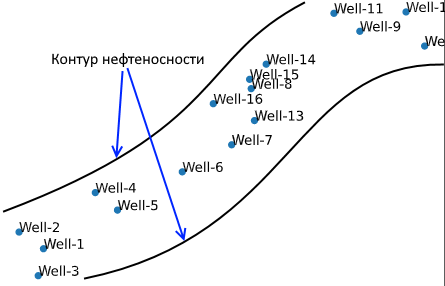

Данная модель слабо чувствительна к местоположению. Модель "не знает" что за пределами определённой зоны нефти нет. Для решения этой проблемы можно было бы найти и загрузить данные по "сухим" скважинам или создать искусственные данные. Мною был вабран вариант не делать ничего. Так как знание области применения модели позволяет отмести неверные результаты и избавляет от дополнительной работы.

### Примечания

1. Цель исследования была в том чтобы понять применимость методов машинного обучения в этой области. Задача выбрать наилучший алгоритм не ставилась, поэтому сравнение наилучшего алгоритма не проводилось

2. Исходные данные для проведения расчётов выложить не могу. У меня нет разрешения для публикации геологических данных.